<a href="https://colab.research.google.com/github/Schumacher-group/post--growing-ca/blob/master/Growing_Neural_Cellular_Automata_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Growing Neural Cellular Automata

This notebook contains code to reproduce experiments and figures for the ["Growing Neural Cellular Automata"](http://distill.pub/2020/growing-ca) article.

Here one can find the [original code](https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/growing_ca.ipynb#scrollTo=QzP_vDchq0d9). 

Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
#@title Mounting 
from google.colab import drive
drive.mount('/content/gdrive')

# drive.flush_and_unmount()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#@title Imports and Notebook Utilities
%tensorflow_version 2.x

%pip install "dask[complete]"
!pip install aicsimageio
!pip install aiohttp
!pip install requests

from aicsimageio import AICSImage
# import os # interactions with the operating system 
import io # file-related input and output operations
import PIL.Image, PIL.ImageDraw 
import base64
import zipfile
import json # compiled code is used to store and transport data
import requests # allows to send http request in python to store data
import numpy as np # support for multi-dimensional arrays and matrices
import matplotlib.pylab as pl # necessary for visualizations
import glob # pathnames

import tensorflow as tf
from tensorflow.keras.layers import Conv2D

import copy

# for tuning 
from tensorflow import keras
! pip install -q -U keras-tuner
import keras_tuner as kt


from IPython.display import Image, HTML, clear_output
import tqdm # shows progress bar 

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg' 
# program to process videos and files in command-line
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

import cv2 # to save videos 

clear_output()

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

In [ ]:
#@title Cellular Automata Parameters
CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = CHANNEL_N   # Number of pixels used to pad the target image border
TARGET_SIZE = 40

BATCH_SIZE = 8 # for Experiment 1 unnecessary 
POOL_SIZE = 1024 # for Experiment 1 unnecessary 

CELL_FIRE_RATE = 0.5

ADD_FRAME = 5

BITS_12 = 4096
BITS_16 = 65536

TARGET_EMOJI = "🦎" #@param {type:"string"}
# 🐽

EXPERIMENT_TYPE = "Growing" #@param ["Growing", "Persistent", "Regenerating"]
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

# manual selection of growing 
USE_PATTERN_POOL = [0][0]
# [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0][0]
# [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

In [ ]:
#@title CA Utilities

# including microenvironment
def to_five(x):
  return x[..., :5]

# excluding microenvironment 
def to_four(x):
  return x[..., :4]

def to_alpha(x):
  # input is a tensor
  # clips values at min 0 and max 1
  return tf.clip_by_value(x[..., 3:4], 0.0, 1.0)

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[..., :3], to_alpha(x)
  return 1.0-a+rgb

def get_living_mask(x):
  alpha = x[:, :, :, 3:4]
  # performs max pooling on input 
  # window size 3
  # stride of the window when sliding 
  # SAME padding 
  return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1

def get_microenvironment(x):
  micro = x[..., 4:5]
  return tf.nn.max_pool2d(micro, 1, [1, 1, 1, 1], 'SAME')  

def make_seed(size, n=1):
  # initialize tensor of certain shape with 0
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x


In [ ]:
#@title CA Model 


class CAModel(tf.keras.Model):
  def __init__(self, 
               channel_n=CHANNEL_N, 
               fire_rate=CELL_FIRE_RATE
  ):
    super().__init__() # initialize 
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    # define neural network after convolution layer 
    # with ReLU activation and simple linear transformation for output
    self.dmodel = tf.keras.Sequential([
                    Conv2D(128, 1, activation=tf.nn.relu),
                    Conv2D(self.channel_n, 1, activation=None,
                           kernel_initializer=tf.zeros_initializer),
                           ])
      
    # idea for initialization, currently not used 
    self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model
  
  
  @tf.function
  def perceive(self, x, angle=0.0):
    identify = np.float32([0, 1, 0])
    # 3 filter 
    # 1. identity filter
    identify = np.outer(identify, identify)
    # Sobel filter for x-axis
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0 
    # Sobel filter for y-axis
    dy = dx.T

    # possible rotation 
    c, s = tf.cos(angle), tf.sin(angle)

    kernel = tf.stack([identify, c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
    kernel = tf.repeat(kernel, self.channel_n, 2)

    # construct perception vector through convolution layer 
    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    return y

  @tf.function
  # implement forward pass of layers in init() function 
  def call(self, x, fire_rate=None, angle=0.0, step_size=0.5):
    pre_life_mask = get_living_mask(x)
    # within_ellipse = get_microenvironment(x)

    y = self.perceive(x, angle)
    
    # residual update for new cell stage 
    dx = self.dmodel(y)*step_size

    # stochastic update of cells 
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
    # output of neural network, masked by stochasticity 
    x += dx * tf.cast(update_mask, tf.float32) 

    post_life_mask = get_living_mask(x)
    # check for aliveness of cells pre and post update 
    # (only if alive at both times a non-zero state is valid)
    life_mask = pre_life_mask & post_life_mask

    # mask acc. to aliveness and and elliptical microenvironment 
    return x * tf.cast(life_mask, tf.float32) 
    # * tf.cast(within_ellipse, tf.float32)


# output model summary 
CAModel().dmodel.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (1, 3, 3, 128)            6272      
_________________________________________________________________
conv2d_59 (Conv2D)           (1, 3, 3, 16)             2064      
Total params: 8,336
Trainable params: 8,336
Non-trainable params: 0
_________________________________________________________________


# Input Images


In [ ]:
#@title Functions for image loading 

# dimensions of image arrays: Heigth, Width, Depth 

# OLD
def load_image(url, max_size=TARGET_SIZE):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0
  # premultiply RGB by Alpha
  img[..., :3] *= img[..., 3:]
  return img

# OLD
# adapted function to read mouse stem cell image
def load_image_real(url, max_size): 
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))

  # resize the image 
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  
  img = np.float32(img)/255.0 
  # 255 as maximum value for white possible, normalization

  # define alpha vector (default 1)
  insert_alpha = [[1]] * max_size

  # add alpha entry 
  img_alpha = np.empty(shape = (len(img), max_size, 4), dtype='object')


  # insert alpha channel 
  for i in range(len(img)):
    subsec = img[i:i+1, ...][0, ...] 
    subsec = np.append(subsec, insert_alpha, axis = 1)
    img_alpha[i:i+1, ...] = subsec


  # get (i, j) positions of all RGB pixels that are black (i.e. [0, 0, 0])
  black_pixels = np.where(
      (img_alpha[:, :, 0] < 0.3) & 
      (img_alpha[:, :, 1] < 0.3) & 
      (img_alpha[:, :, 2] < 0.3)
  )

  # set those pixels to white
  img_alpha[black_pixels] = [1., 1., 1., 0.]

  # encode as float number 
  img_alpha = np.float32(img_alpha)
  
  # premultiply RGB by Alpha
  img_alpha[..., :3] *= img_alpha[..., 3:]

  return(img_alpha)

# OLD
def load_emoji(emoji):
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
  return load_image(url)


# USED

# adds dark frame around cell colony to enable edge detection
def framed(image, add_frame):
  frame_value = 0
  #image[0, 0, 0]

  image_height = image.shape[1]
  image_width = image.shape[2]

  desired_height = image_height + 2 * add_frame
  desired_width = image_width + 2 * add_frame

  frame = np.full((1, desired_height, desired_width), frame_value, dtype = np.float32)

  frame[0, add_frame:add_frame + image.shape[1], add_frame:add_frame + image.shape[2]] = image

  return frame

# add microenvironment column which encodes the elliptical shape 
def define_microenvironment(image, threshold, bits):
  threshold_index = np.where(image[0, :, :,] > threshold)

  new_array = np.zeros(image.shape)
  new_array[0][threshold_index] = bits
  return new_array

def add_microenvironment(image, microenvironment):
  image = np.concatenate((image, microenvironment), 
                         axis = 0)
  # set all pixels outside ellipse to 0 
  image[:4, ...] *= image[4, ...]
  return image

def load_image_tiff(url, add_frame, bits):
  img = AICSImage(url)

  # read inividual channels and add frame 
  # GSC
  image0 = framed(np.float32(img.get_image_data('ZYX',T=0,C=0)), add_frame)
  # Lamina B
  image1 = framed(np.float32(img.get_image_data('ZYX',T=0,C=1)), add_frame)
  # SOX2
  image2 = framed(np.float32(img.get_image_data('ZYX',T=0,C=2)), add_frame)
  # Brachyury (T)
  image3 = framed(np.float32(img.get_image_data('ZYX',T=0,C=3)), add_frame)

  # concatenate channel arrays 
  image = np.concatenate((image0, image2, image3, image1), 
                         axis=0)
  img = np.float32(image) / bits

   
  return img, image0, image1, image2, image3


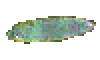

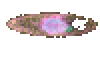

(30, 50, 4)
(30, 50, 4)


In [ ]:
#@title Read RGB Image { vertical-output: true}

# width of the target image (height constructed porportionally)
desired_size = 50 


# 1) mouse stem cell image as input 
  # a. after 48 hours
url_cell_intermediate ='https://raw.githubusercontent.com/Schumacher-group/post--growing-ca/master/data/S2_48h_Col_1_scaled(RGB)_212x129.tif?raw=true'

  # b. after 60 hours
url_cell_final = 'https://raw.githubusercontent.com/Schumacher-group/post--growing-ca/master/data/S2_60h_Col_1_scaled(RGB)_217x129.tif?raw=true'

intermediate_old = load_image_real(url_cell_intermediate, desired_size)
final_old = load_image_real(url_cell_final, desired_size)

#intermediate_img = intermediate_old
#target_img = final_old

# 2) emoji as input  
# target_img = load_emoji(TARGET_EMOJI)

imshow(zoom(to_rgb(intermediate_old), 2), fmt='png')
imshow(zoom(to_rgb(final_old), 2), fmt='png')

print(intermediate_old.shape)
print(final_old.shape)

#intermediate_img = intermediate_old
#target_img = final_old


In [ ]:
#@title Read TIFF image { vertical-output: true}

# Documentation: https://allencellmodeling.github.io/aicsimageio/aicsimageio.aics_image.AICSImage.html

url_intermediate = 'https://github.com/Schumacher-group/post--growing-ca/blob/master/data/48_h_downsized-2.tif?raw=true'

url_final = 'https://github.com/Schumacher-group/post--growing-ca/blob/master/data/60_h_downsized.tif?raw=true'

img_intermediate_prelim, image_intermediate_GSC, image_intermediate_lamina, image_intermediate_SOX2, image_intermediate_TBRA = load_image_tiff(url_intermediate, ADD_FRAME, BITS_12)
img_final_prelim, image_final_GSC, image_final_lamina, image_final_SOX2, image_final_TBRA = load_image_tiff(url_final, ADD_FRAME, BITS_16)

microenvironment_intermediate = define_microenvironment(image_intermediate_lamina, 400, BITS_12)
microenvironment_final = define_microenvironment(image_final_lamina, 5000, BITS_16)

# set to biggest microenvironment 
microenvironment = microenvironment_final + microenvironment_intermediate
microenvironment[np.where(microenvironment > 0)] = 1

img_intermediate_prelim = add_microenvironment(img_intermediate_prelim, microenvironment)
img_final_prelim = add_microenvironment(img_final_prelim, microenvironment)

# check if microenvironment for both images is identical 
print(np.where(img_final_prelim[4, ...] != img_intermediate_prelim[4, ...]))

# transpose necessary to bring into wanted formate 
intermediate_img = img_intermediate_prelim.T
target_img = img_final_prelim.T

print(intermediate_img.shape)
print(target_img.shape)


Failed to parse XML for the provided file.
not well-formed (invalid token): line 1, column 6
Failed to parse XML for the provided file.
not well-formed (invalid token): line 1, column 6


(array([], dtype=int64), array([], dtype=int64))
(58, 26, 5)
(58, 26, 5)


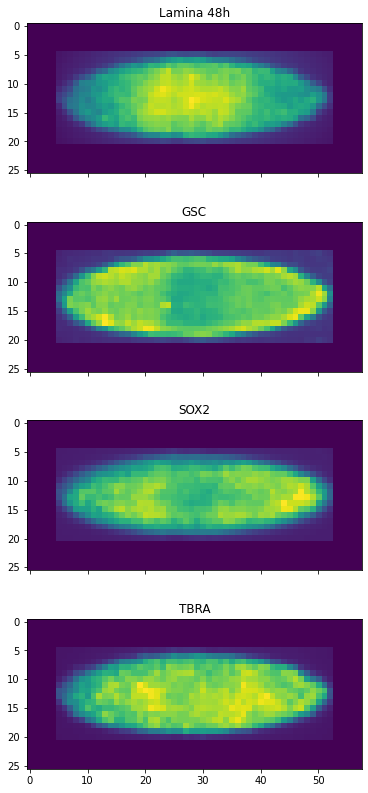

In [ ]:
#@title Plot channels to intermediate image { vertical-output: true}
from matplotlib import pyplot as plt

# image_intermediate_lamina[0]
# image_intermediate_GSC[0]
# image_intermediate_SOX2[0]
# image_intermediate_TBRA[0]
# plot original image and edges 
fig2, (ax1, ax2, ax3, ax4) = pl.subplots(ncols=1, nrows=4, figsize=(6, 14),
                                sharex=True, sharey=True)

ax1.set_title('Lamina 48h')
ax1.imshow(image_intermediate_lamina[0])

ax2.set_title('GSC')
ax2.imshow(image_intermediate_GSC[0])

ax3.set_title('SOX2')
ax3.imshow(image_intermediate_SOX2[0])

ax4.set_title('TBRA')
ax4.imshow(image_intermediate_TBRA[0])

pl.show()

fig2.savefig('48_h_compare_channels.eps', format='eps')
plt.close(fig2)


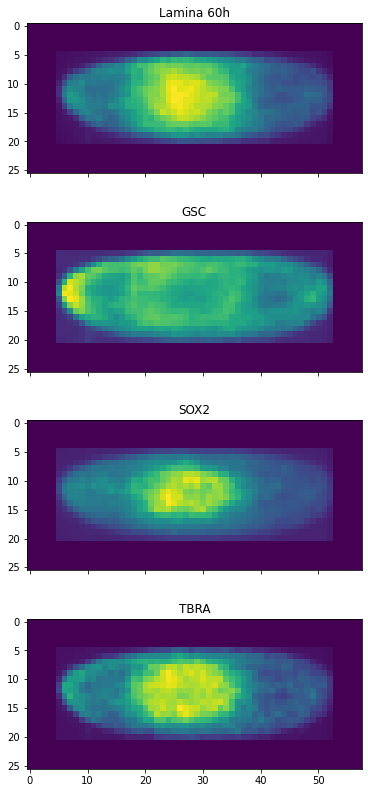

In [ ]:
#@title Plot channels to final image { vertical-output: true}

#pl.imshow(image_final_GSC[0])
# image_final_GSC[0]
# image_final_SOX2[0]
# image_final_lamina[0]
# image_final_TBRA[0]

fig3, (ax1, ax2, ax3, ax4) = pl.subplots(ncols=1, nrows=4, figsize=(6, 14),
                                sharex=True, sharey=True)

ax1.set_title('Lamina 60h')
ax1.imshow(image_final_lamina[0])

ax2.set_title('GSC')
ax2.imshow(image_final_GSC[0])

ax3.set_title('SOX2')
ax3.imshow(image_final_SOX2[0])

ax4.set_title('TBRA')
ax4.imshow(image_final_TBRA[0])

pl.show()

fig3.savefig('60_h_compare_channels.eps', format='eps')
plt.close(fig3)


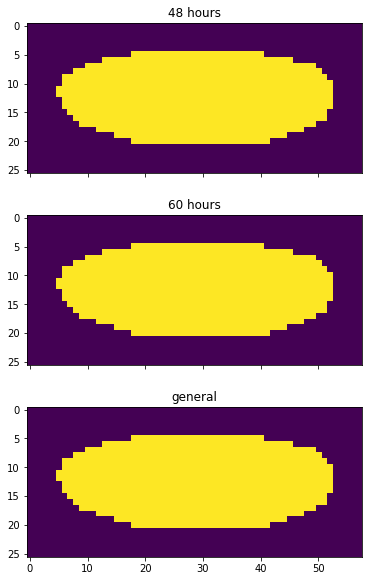

In [ ]:
#@title Plot microenvironment 
fig_micro, (ax1, ax2, ax3) = pl.subplots(ncols=1, nrows=3, figsize=(6, 10),
                                sharex=True, sharey=True)

ax1.set_title('48 hours')
ax1.imshow(img_intermediate_prelim[4, ...])

ax2.set_title('60 hours')
ax2.imshow(img_final_prelim[4,  ...])

ax3.set_title('general')
ax3.imshow(microenvironment[0])

fig_micro.savefig('microenvironment.eps', formate='eps')


In [ ]:
#@title Calculate size and range of arrays { vertical-output: true}

def minmax(image):
  minimum = min(min(image[0].tolist()))
  maximum = max(max(image[0].tolist()))
  return minimum, maximum

print("48 hours (Lamina - SOX2 - TBRA - GSC)")
print(minmax(image_intermediate_lamina))
print(minmax(image_intermediate_SOX2))
print(minmax(image_intermediate_TBRA))
print(minmax(image_intermediate_GSC))

print("")
print("60 hours (same order)")
print(minmax(image_final_lamina))
print(minmax(image_final_SOX2))
print(minmax(image_final_TBRA))
print(minmax(image_final_GSC))

print("")
print("range of output images")
print(np.ptp(intermediate_img, axis = (0, 1, 2)))
print(np.ptp(target_img, axis = (0, 1, 2)))


48 hours (Lamina - SOX2 - TBRA - GSC)
(0.0, 1219.0)
(0.0, 1373.0)
(0.0, 1640.0)
(0.0, 999.0)

60 hours (same order)
(0.0, 45361.0)
(0.0, 28822.0)
(0.0, 41641.0)
(0.0, 26130.0)

range of output images
1.0
1.0


Index(['Centroid X', 'Centroid Y', 'Centroid Z', 'Database ID', 'Image Name',
       'Intensity Variance GSC', 'Intensity Variance LMBR',
       'Intensity Variance SOX2', 'Intensity Variance TBRA', 'Is Border',
       'Kurtosis Intensity GSC', 'Kurtosis Intensity LMBR',
       'Kurtosis Intensity SOX2', 'Kurtosis Intensity TBRA', 'Location X',
       'Location Y', 'Location Z', 'Max Intensity GSC', 'Max Intensity LMBR',
       'Max Intensity SOX2', 'Max Intensity TBRA', 'Mean Intensity GSC',
       'Mean Intensity LMBR', 'Mean Intensity SOX2', 'Mean Intensity TBRA',
       'Median Intensity GSC', 'Median Intensity LMBR',
       'Median Intensity SOX2', 'Median Intensity TBRA', 'Min Intensity GSC',
       'Min Intensity LMBR', 'Min Intensity SOX2', 'Min Intensity TBRA',
       'Normalised Coordinate 0', 'Normalised Coordinate 1',
       'Normalised Coordinate 2', 'Second Moment 0', 'Second Moment 1',
       'Second Moment 2', 'Sum Intensity GSC', 'Sum Intensity LMBR',
       'Sum Inten

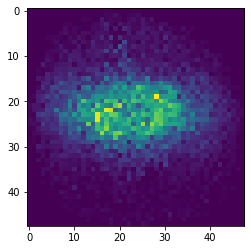

In [ ]:
#@title Read average data { vertical-output: true}

# Importing necessary Libraries
import numpy as np
import pandas as pd

from skimage.transform import hough_ellipse

# Read table
# Read the data as a pandas frame
df = pd.read_csv("https://github.com/Schumacher-group/post--growing-ca/blob/master/data/210427_S2_results?raw=true", sep='\t')
print(df.columns)

# Remove all nuclei too close from pattern autofluorescence
df = df.loc[df['Normalised Coordinate 2'] > -3]


# define markers
markers = ["SOX2", "TBRA", "GSC"]

# define timepoints (conditions)
timepoints = ["36h", "48h", "60h"]
timepoint = '60h'

# create a new column to specify conditions
predicates = [(df['Image Name'].str.contains(x)) for x in timepoints]
df['Time Point'] = np.select(predicates, timepoints)
df[['Image Name', 'Time Point']].head()


# subset data acc. to timepoint 
df_subset = df.loc[df['Time Point']==timepoint]
  
# isolate relevant columns 
y = df_subset['Normalised Coordinate 0']
x = df_subset['Normalised Coordinate 1']
points = df_subset[['Normalised Coordinate 1', 'Normalised Coordinate 0']]

# mean intensity for marker proteins 
SOX2 = df_subset['Mean Intensity SOX2']
TBRA = df_subset['Mean Intensity TBRA']
GSC = df_subset['Mean Intensity GSC']

# number of bins to which image will be alloted
bin_number = 48

# create array with count entries for each bin
H, xedges, yedges = np.histogram2d(x, y, bins = bin_number)
H = H.T

# create second array to use as a divisor
H_divisor = np.histogram2d(x, y, bins = bin_number)[0].T
H_divisor[np.where(H == 0)] = 1

# create arrays with sum of mean intensities and divide to get mean of mean intensities
H_SOX2 = np.histogram2d(x, y, bins = bin_number, weights=SOX2)[0].T
H_mean_SOX2 = H_SOX2/ H_divisor
H_TBRA = np.histogram2d(x, y, bins = bin_number, weights=TBRA)[0].T
H_mean_TBRA = H_TBRA / H_divisor
H_GSC = np.histogram2d(x, y, bins = bin_number, weights=GSC)[0].T
H_mean_GSC = H_GSC / H_divisor

# create dead / alive column as a binary column 
H_lamina = np.histogram2d(x, y, bins = bin_number)[0].T
H_lamina[np.where(H_lamina != 0)] = 1



H_mean_SOX2_reformated = H_mean_SOX2.reshape((H_mean_SOX2.shape[0], H_mean_SOX2.shape[1], 1))
H_mean_TBRA_reformated = H_mean_TBRA.reshape((H_mean_TBRA.shape[0], H_mean_TBRA.shape[1], 1))
H_mean_GSC_reformated = H_mean_GSC.reshape((H_mean_GSC.shape[0], H_mean_GSC.shape[1], 1))
H_lamina_reformated = H_lamina.reshape((H_lamina.shape[0], H_lamina.shape[1], 1))



H_array = np.concatenate((H_mean_SOX2_reformated, 
                          H_mean_TBRA_reformated, 
                          H_mean_GSC_reformated, 
                          H_lamina_reformated), axis = 2)

# Visualization and check
pl.imshow(H_SOX2)
#pl.imshow(H_mean_GSC)
#pl.imshow(H_mean_TBRA)
#pl.imshow(H_lamina, vmax = 1)

# print(H_array.shape)


# Training

In [ ]:
#@title Train Utilities (SamplePool, Model Export, Damage)
from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants

class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

#@tf.function
def make_circle_masks(n, h, w):
  x = tf.linspace(-1.0, 1.0, w)[None, None, :]
  y = tf.linspace(-1.0, 1.0, h)[None, :, None]
  center = tf.random.uniform([2, n, 1, 1], -0.5, 0.5)
  r = tf.random.uniform([n, 1, 1], 0.1, 0.4)
  x, y = (x-center[0])/r, (y-center[1])/r
  mask = tf.cast(x*x+y*y < 1.0, tf.float32)
  return mask

def export_model(ca, base_fn):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, CHANNEL_N]),
      fire_rate=tf.constant(0.5),
      angle=tf.constant(0.0),
      step_size=tf.constant(1.0))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

def generate_pool_figures(pool, step_i):
  tiled_pool = tile2d(to_rgb(pool.x[:49]))
  fade = np.linspace(1.0, 0.0, 72)
  ones = np.ones(72) 
  tiled_pool[:, :72] += (-tiled_pool[:, :72] + ones[None, :, None]) * fade[None, :, None] 
  tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :, None]) * fade[None, ::-1, None]
  tiled_pool[:72, :] += (-tiled_pool[:72, :] + ones[:, None, None]) * fade[:, None, None]
  tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None, None]) * fade[::-1, None, None]
  imwrite('train_log/%04d_pool.jpg'%step_i, tiled_pool)

def visualize_batch(x0, x, step_i):
  vis0 = np.hstack(to_rgb(x0).numpy())
  vis1 = np.hstack(to_rgb(x).numpy())
  vis = np.vstack([vis0, vis1])
  imwrite('train_log/batches_%04d.jpg'%step_i, vis)
  print('batch (before/after):')
  imshow(vis)

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()


In [ ]:
#@title Define Training functions { vertical-output: true}

# define loss function for backpropagation
def loss_f(x, target_image):
  # only difference in first 5 columns relevant 
  return tf.reduce_mean(tf.square(to_five(x) - to_five(target_image)), [-2, -3, -1])
  # to_five(x)


# @tf.function
def train_step_two_targets(x, pad_intermediate, pad_target):
  # observation after 48 and 60 hours 
  iter_n_intermediate = 48
  iter_n = 60

  # first neural network for update rule up to 48 hours 
  with tf.GradientTape() as g:
    for i in tf.range(iter_n_intermediate):
      # send x once through neural network and use output as input for next iteration
      x = ca_1(x)
    loss_intermediate = tf.reduce_mean(loss_f(x, pad_intermediate))
    
  grads_1 = g.gradient(loss_intermediate, ca_1.weights)
  grads_1 = [g/(tf.norm(g)+1e-8) for g in grads_1]
  trainer.apply_gradients(zip(grads_1, ca_1.weights))

  # second neural network for update rule up to 60 hours
  with tf.GradientTape() as g:
    for i in tf.range(start = iter_n_intermediate, limit = iter_n):
      x = ca_2(x)
    loss_final = tf.reduce_mean(loss_f(x, pad_target))
      # reduces loss (difference between RGB value of current output and target) across all three dimensions 

  grads_2 = g.gradient(loss_final, ca_2.weights)
  grads_2 = [g/(tf.norm(g)+1e-8) for g in grads_2]
  trainer.apply_gradients(zip(grads_2, ca_2.weights))

  return x, loss_intermediate, loss_final 


  # @tf.function
def train_intermediate(x, pad_intermediate):
  # first neural network for update rule up to 48 hours 
  iter_n_intermediate = 48
  with tf.GradientTape() as g:
    for i in tf.range(iter_n_intermediate):
      # send x once through neural network and use output as input for next iteration
      x = ca_1(x)
    loss_intermediate = tf.reduce_mean(loss_f(x, pad_intermediate))
    
  grads_1 = g.gradient(loss_intermediate, ca_1.weights)
  grads_1 = [g/(tf.norm(g)+1e-8) for g in grads_1]
  trainer.apply_gradients(zip(grads_1, ca_1.weights))

  return x, loss_intermediate #, ca_1.weights 

def train_final(x, pad_final):
  # second neural network for update rule to 60 hours
  iter_n_intermediate = 48
  iter_n_final = 60
  with tf.GradientTape() as g:
    for i in tf.range(start = iter_n_intermediate, limit = iter_n_final):
      x = ca_2(x)
    loss_final = tf.reduce_mean(loss_f(x, pad_final))
      # reduces loss (difference between RGB value of current output and target) across all three dimensions 

  grads_2 = g.gradient(loss_final, ca_2.weights)
  grads_2 = [g/(tf.norm(g)+1e-8) for g in grads_2]
  trainer.apply_gradients(zip(grads_2, ca_2.weights))
  return x, loss_final



# create neural CA object 
ca1 = CAModel()
ca2 = CAModel()

def train_step(x, iter_n, target):
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca(x)
    loss = tf.reduce_mean(loss_f(x, target))
  grads = g.gradient(loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, loss

def train_step_1(x, iter_n, target):
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca1(x)
    loss = tf.reduce_mean(loss_f(x, target))
  grads = g.gradient(loss, ca1.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca1.weights))
  return x, loss 

def train_step_2(x, iter_n, target):
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca2(x)
    loss = tf.reduce_mean(loss_f(x, target))
  grads = g.gradient(loss, ca2.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca2.weights))
  return x, loss 



In [ ]:
#@title Training Initialization { vertical-output: true}

# padding = adding a frame (additional array entries)
p = TARGET_PADDING
pad_intermediate = np.float32(tf.pad(intermediate_img, [(p, p), (p, p), (0, 0)]))
pad_target = np.float32(tf.pad(target_img, [(p, p), (p, p), (0, 0)]))

h, w = pad_target.shape[:2]
orig_h, orig_w = target_img.shape[:2]

delta_h = np.int((h - orig_h) / 2)
delta_w = np.int((w - orig_w) / 2)

# INTITIAL STATE 
# define one single black pixel seed state
seed_prelim = np.zeros([CHANNEL_N, w, h], np.float32)
seed_prelim[3:, w//2, h//2] = 1.0

# add microenvironment information 
seed_prelim[4, delta_w:(delta_w + orig_w), delta_h:(delta_h + orig_h)] = microenvironment[0]

seed = np.float32(seed_prelim.T)
# alternatively: ellipse filled with SOX2 positive cells 


# empty array to save log loss value in each training iteration 
loss_log_intermediate = []
loss_log_final = []

# schedule for the learning rate
lr = 2e-6
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr, lr*0.1])

# define ADAM algorithm to optimize 
trainer = tf.keras.optimizers.Adam(lr_sched)

# initial loss for seed (maximum loss)
loss0_intermediate = loss_f(seed, pad_intermediate).numpy()
loss0_final = loss_f(seed, pad_target).numpy()

print(loss0_intermediate)
print(loss0_final)

# initial set up of the batch pool
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))

!mkdir -p train_log && rm -f train_log/*

0.004561948
0.009525271


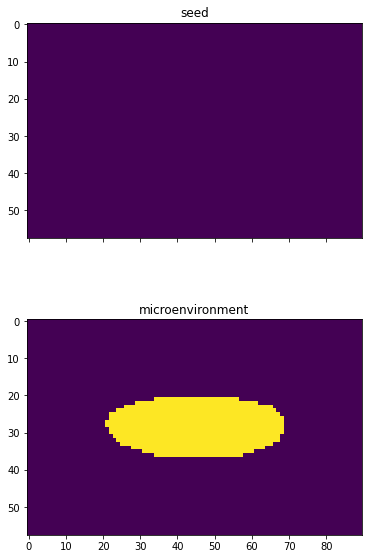

In [ ]:
#@title Plot seed and its microenvironment 

fig_seed, (ax1, ax2) = pl.subplots(ncols=1, nrows=2, figsize=(6, 10),
                                sharex=True, sharey=True)

ax1.set_title('seed')
ax1.imshow(seed_prelim[0])

ax2.set_title('microenvironment')
ax2.imshow(seed_prelim[4])

fig_seed.savefig('seed_microenv.eps', formate='eps')

In [ ]:
y, loss = train_step(x0, 48, pad_intermediate) 

(16, 58, 90)
(array([0, 0, 0, ..., 7, 7, 7]), array([21, 21, 22, ..., 68, 68, 68]), array([27, 28, 25, ..., 28, 29, 30]), array([4, 4, 4, ..., 4, 4, 4]))
(8, 90, 58, 16)
(8, 90, 58, 16)


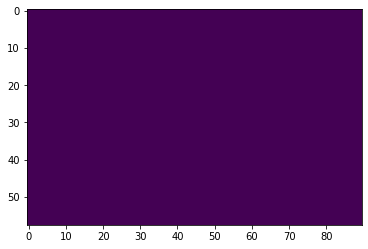

In [ ]:
print(seed_prelim.shape)
print(np.where(y != seed))
print(y.shape)

new_y = np.array(y[5, ...], np.float32).T
pl.imshow(seed_prelim[4])
pl.imshow(new_y[1])
np.where(new_y[1] != 0)

#pl.imshow(pad_target.T[4])

print(x.shape)


 48 hours


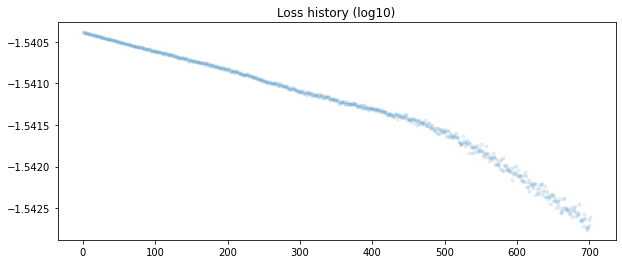

 60 hours


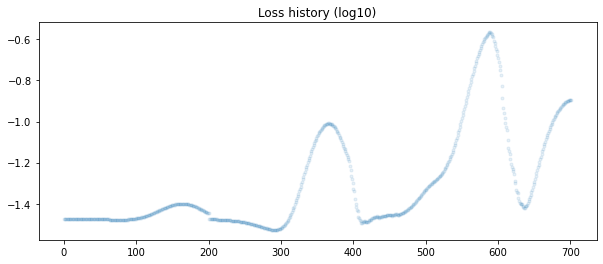

 training required 5630.066 seconds

In [ ]:
#@title Training Loop {vertical-output: true}
import time # to stop the time training takes
# neural cellular automata (calling the object)

start = time.clock()
for i in range(1000+1): 
  x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)

  x, loss_intermediate = train_step_1(x0, 48, pad_intermediate) 
  
  step_i = len(loss_log_intermediate)
  loss_log_intermediate.append(loss_intermediate.numpy())
  export_model(ca, 'train_log_intermediate/%04d'%step_i)


for i in range(1000+1): 
  x, loss_final = train_step_2(x, 12 , pad_target)
  
  step_i = len(loss_log_final)
  loss_log_final.append(loss_final.numpy())
  export_model(ca, 'train_log_final/%04d'%step_i)

  

print('\r 48 hours')
plot_loss(loss_log_intermediate)
print('\r 60 hours')
plot_loss(loss_log_final)

end = time.clock()

print('\r training required %.3f seconds'%(end - start), end='')




#Figures

In [ ]:
#@title Training Progress (Checkpoints)

models = []
for i in [50, 100, 200, 500, 1000]:
  ca1 = CAModel()
  ca2 = CAModel()

  ca1.load_weights('train_log_intermediate/%04d'%i)
  ca2.load_weights('train_log_final/%04d'%i)
  models.append(ca1)
  models.append(ca2)

out_fn = 'train_steps_damage_%d.mp4'%DAMAGE_N
x = np.zeros([len(models), 72, 72, CHANNEL_N], np.float32)
x[..., 36, 36, 3:] = 1.0
with VideoWriter(out_fn) as vid:
  for i in tqdm.trange(500):
    vis = np.hstack(to_rgb(x))
    vid.add(zoom(vis, 2))
    for ca, xk in zip(models, x):
      xk[:] = ca(xk[None,...])[0]
mvp.ipython_display(out_fn)


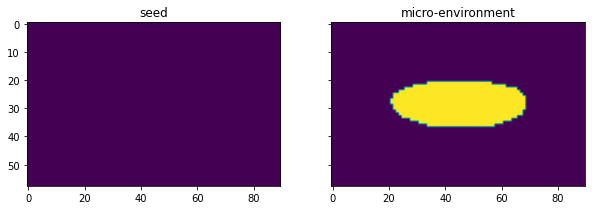

In [ ]:
#@title Plots for slides 

fig_seed_h, (ax1, ax2) = pl.subplots(ncols=2, nrows=1, figsize=(10, 6),
                                sharex=True, sharey=True)

ax1.set_title('seed')
ax1.imshow(seed_prelim[0, ...])

ax2.set_title('micro-environment')
ax2.imshow(seed_prelim[4, ...])

fig_seed_h.savefig('seed_h.eps', formate='eps')


# Saving

In [ ]:
#@title Save models 
ca_1.save('NN_intermediate_default_params')
ca_2.save('NN_final_default_params')

%cp -R /content/NN_intermediate_default_params /content/gdrive/My\ Drive/Neural_cellular_automata/
%cp -R /content/NN_final_default_params /content/gdrive/My\ Drive/Neural_cellular_automata/

INFO:tensorflow:Assets written to: NN_intermediate_default_params/assets
INFO:tensorflow:Assets written to: NN_final_default_params/assets


In [ ]:
#@title Save loss 

import pickle

file_name = 'loss_default_params.pckl'
f = open(file_name, 'wb')
pickle.dump([loss_log_intermediate, loss_log_final], f)
f.close()

In [ ]:
#@title Loading 

# 1. Model
# https://stackoverflow.com/questions/53295570/userwarning-no-training-configuration-found-in-save-file-the-model-was-not-c
loaded_model = tf.keras.models.load_model('NN_intermediate_default_params', 
                                          compile=False)
loaded_model.weights


In [ ]:
#2. Variables
# https://stackoverflow.com/questions/6568007/how-do-i-save-and-restore-multiple-variables-in-python
file_name = 'loss_default_params.pckl'
f = open(file_name, 'rb')
obj = pickle.load(f)
f.close()

# Tuning and comparison 


In [ ]:
#@title Compare performance

print(min(loss_log))

# lizard: 4.293312e-05 
# pig nose: 0.0001504272
# stem cell 
  # 48h: 6.941299e-05
  # 60h: 6.555613e-05

# compare loss at the end 
loss_compare = []

pl.figure(figsize=(10, 4))
  pl.title('Loss comparison (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()

In [ ]:
#@title Define parameters 

# subsection Cellular Automata Parameters 

In [ ]:
#@title Compare performance of hyperparameter choice 